In [1]:
import scanpy as sc 
import pandas as pd
import SEACells
import numpy as np
import matplotlib
from statistics import mode
import matplotlib.pyplot as plt
from statistics import mode

import sys 
sys.path.insert(0, '../')
import utils
from importlib import reload
reload(utils)
from utils import *
import seaborn as sns
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
data_path = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Data/"
save_path_results = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Results/"

2024-11-05 14:40:50.496103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-05 14:40:55.278166: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [5]:
adata = sc.read(data_path+"nault2021_singleDose.h5ad")
#Prepare Data Set
cell_types_of_int = ["Hepatocytes - portal", "Hepatocytes - central", "Cholangiocytes", "Stellate Cells", "Portal Fibroblasts", "Endothelial Cells"]
adata = adata[adata.obs['celltype'].isin(cell_types_of_int)].copy()

cell_types_of_int = ["Hepatocytes - central", "Hepatocytes - portal", "Cholangiocytes", "Stellate Cells", "Portal Fibroblasts", "Endothelial Cells"]

adata

AnnData object with n_obs × n_vars = 18865 × 22213
    obs: 'Dose', 'batch', 'celltype'

In [3]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
adata = adata[:, adata.var[(adata.var.mt == False) & (adata.var.ribo == False)].index.values]
adata

View of AnnData object with n_obs × n_vars = 18865 × 22213
    obs: 'Dose', 'batch', 'celltype'
    var: 'mt', 'ribo'

In [4]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True)
adata

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


AnnData object with n_obs × n_vars = 18865 × 22213
    obs: 'Dose', 'batch', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

<Axes: xlabel='total_counts', ylabel='n_genes_by_counts'>

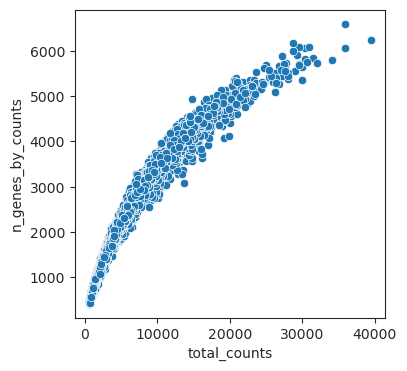

In [5]:
sns.scatterplot(data=adata.obs, x="total_counts", y="n_genes_by_counts")

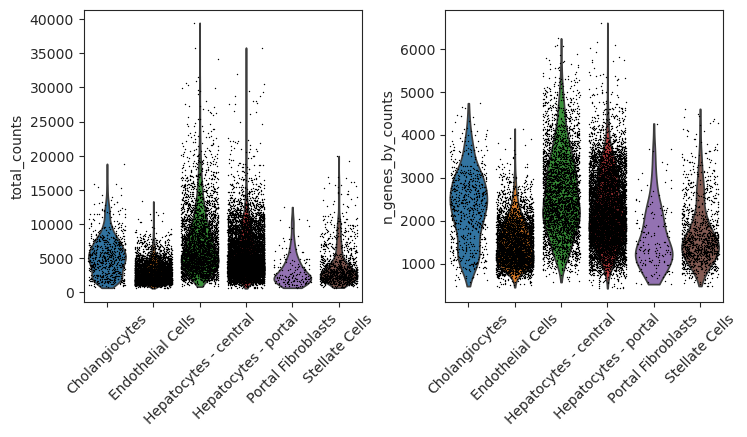

In [6]:
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts']
             ,jitter=0.4, groupby = 'celltype', rotation= 45)

In [7]:
# basic qc and pp
print(adata)
adata.layers['counts'] = adata.X.copy()

# remove cells that have less than 1000 counts
sc.pp.filter_cells(adata, min_counts=1000, inplace =True)

# remove genes that are detected in less than 20 cells
sc.pp.filter_genes(adata, min_cells=50, inplace =True)
adata.X.A.max()

AnnData object with n_obs × n_vars = 18865 × 22213
    obs: 'Dose', 'batch', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltype_colors'


3247.0

In [8]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [9]:
adata.obs['perturbation'] = 'control'
adata.obs.loc[adata.obs.Dose == 30, 'perturbation'] = 'TCDD'

In [10]:
adata.obs.rename({"celltype": "cell_type"}, axis=1, inplace=True)
adata.obs.rename({"perturbation": "condition"}, axis=1, inplace=True)

In [11]:
from sklearn.preprocessing import LabelEncoder
adata.obs['drug_dose_name'] = adata.obs.condition.astype(str) + '_' + adata.obs.Dose.astype(str)
adata.obs['cov_drug_dose_name'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.drug_dose_name.astype(str)
adata.obs['cov_drug'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)
label_encoder = LabelEncoder()
adata.obs["condition_label"] = label_encoder.fit_transform(adata.obs["condition"])
num_perts = adata.obs["condition_label"].values.max()+1
num_perts
print((adata.obs['cov_drug_dose_name'].unique()))

['Stellate Cells_control_0' 'Hepatocytes - portal_control_0'
 'Endothelial Cells_control_0' 'Cholangiocytes_control_0'
 'Hepatocytes - central_control_0' 'Portal Fibroblasts_control_0'
 'Endothelial Cells_TCDD_30' 'Hepatocytes - portal_TCDD_30'
 'Cholangiocytes_TCDD_30' 'Hepatocytes - central_TCDD_30'
 'Stellate Cells_TCDD_30' 'Portal Fibroblasts_TCDD_30']


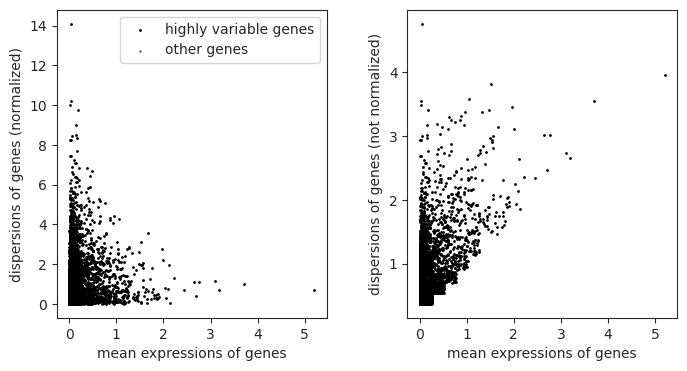

In [12]:
sc.pp.highly_variable_genes(adata, subset=True, n_top_genes = 5000)
sc.pl.highly_variable_genes(adata)

In [13]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturb

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


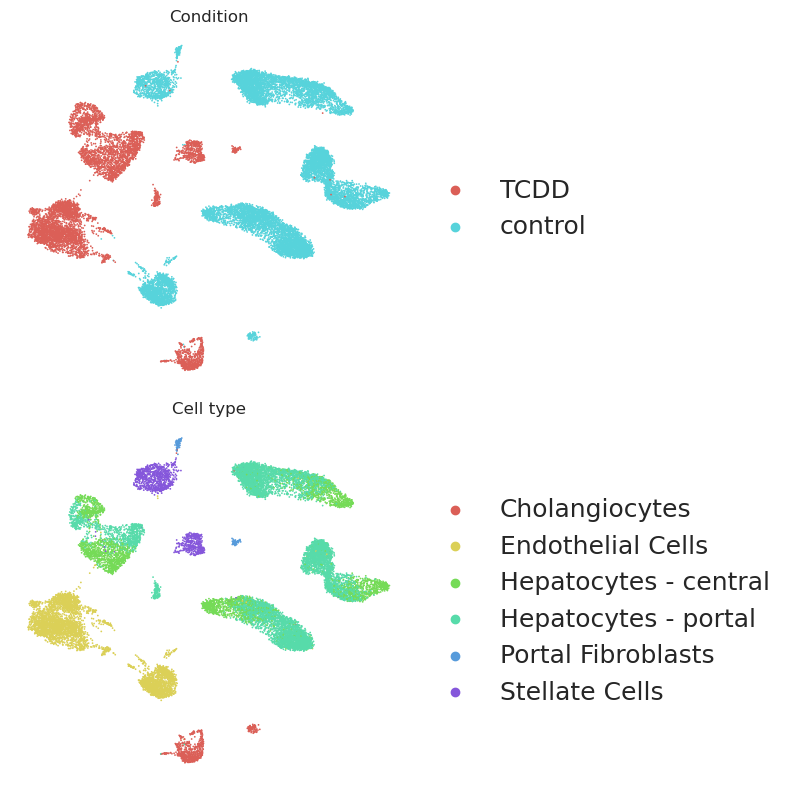

In [14]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 8))  # Adjust figsize as needed
# Plot UMAP 1 in the first subplot if it's not empty
sc.pl.umap(adata=adata, color=["condition"],legend_fontsize=18,ax = axes[0],
           title = "Condition",
           show=False, palette = sns.color_palette("hls", 2),
           frameon=False)

sc.pl.umap(adata=adata, color=["cell_type"],legend_fontsize=18,ax = axes[1],
           title = "Cell type",
           show=False, palette = sns.color_palette("hls", 7),
           frameon=False)

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig(save_path_results+'UMAP_Nault.pdf', bbox_inches='tight')
# Show the merged plot
plt.show()

In [15]:
adata.write(data_path+'Nault.h5ad')

In [16]:
adata.var = adata.var.reset_index()
adata.var.rename({"index": "gene_symbol"}, axis=1, inplace=True)
adata.var.set_index("gene_symbol", inplace = True)

In [17]:
ctrl_data = adata[adata.obs.condition == 'control'].copy()
ctrl_data

AnnData object with n_obs × n_vars = 12452 × 5000
    obs: 'Dose', 'batch', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'condition', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'condition_label'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [18]:
n_SEACells = int(len(ctrl_data) / 50)
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
n_SEACells

249

In [19]:
model = SEACells.core.SEACells(ctrl_data, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [20]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/12452 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/12452 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/12452 [00:00<?, ?it/s]

Constructing CSR matrix...


In [21]:
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 221 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 38/38 [00:00<00:00, 45.70it/s]

Selecting 28 cells from greedy initialization.


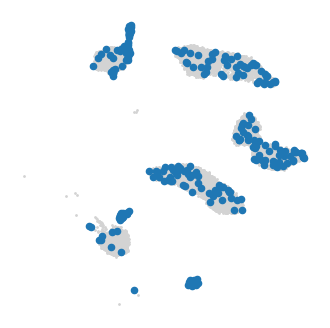

In [22]:
SEACells.plot.plot_initialization(ctrl_data, model)

In [23]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Setting convergence threshold at 0.00203
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 34 iterations.


In [24]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 35 iterations
Ran for 40 iterations


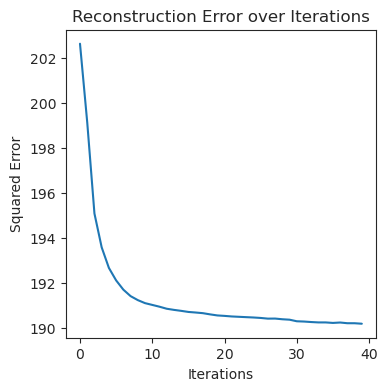

In [25]:
model.plot_convergence()

In [26]:
adata.obs['SEACell'] = 'None'
adata.obs.loc[ctrl_data.obs.index.tolist(), 'SEACell'] = ctrl_data.obs['SEACell'].values

In [27]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ctrl_data,  model.A_, 
                                                          celltype_label='cell_type', summarize_layer = 'counts', minimum_weight = 0.05)
SEACell_soft_ad.X.A

100%|██████████| 249/249 [01:41<00:00,  2.44it/s]


array([[0.00362838, 0.00262597, 0.00409753, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06605943, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00358554, 0.04509973, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00641627, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00990313, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02607457, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [28]:
SEACell_soft_ad.obs.celltype.value_counts()

celltype
Hepatocytes - portal     128
Hepatocytes - central     50
Endothelial Cells         32
Stellate Cells            26
Cholangiocytes             7
Portal Fibroblasts         6
Name: count, dtype: int64

In [29]:
SEACell_soft_ad.obs
SEACell_soft_ad.obs.rename({"celltype": "cell_type"}, axis=1, inplace=True)
SEACell_soft_ad.write(data_path+'SEACell_soft_ad_Nault.h5ad')

In [30]:
adata.write(data_path+'Nault.h5ad')

In [2]:
SEACell_soft_ad = sc.read(data_path+'SEACell_soft_ad_Nault.h5ad')
SEACell_soft_ad

AnnData object with n_obs × n_vars = 249 × 5000
    obs: 'Pseudo-sizes', 'cell_type', 'celltype_purity'

In [3]:
SEACell_soft_ad.var.reset_index(inplace = True)
SEACell_soft_ad.var
SEACell_soft_ad.var.rename({"index": "gene_symbol"}, axis=1, inplace=True)
SEACell_soft_ad.var.set_index("gene_symbol", inplace = True)

In [4]:
import os
import networkx as nx
from torch_geometric.utils.convert import from_networkx
from sklearn.metrics import mean_squared_error
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip, HeteroData, Batch
from torch_geometric.utils import *
import torch
from torch import nn
cell_type_network = {}
# Leaf directory 
directory = "Nault"
parent_dir = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in SEACell_soft_ad.obs.cell_type.unique():
    print(cell_type)
    cell = Correlation_matrix(SEACell_soft_ad, cell_type, 'cell_type',
                       hv_genes_cells = None, union_HVGs = True)
    threshold = np.percentile(np.abs(cell[0].values), 99.0)
    print("threshold:", threshold)
    
    g = create_coexpression_graph(SEACell_soft_ad, cell, cell_type, threshold, 'gene_symbol')
    if g.num_nodes >= max_nodes:
        max_nodes = g.num_nodes
    cell_type_network[cell_type] = g
    genes_pos.append(cell_type_network[cell_type].pos)
    cell_type_network[cell_type].pos = torch.tensor(cell_type_network[cell_type].pos)
    torch.save(cell_type_network[cell_type] , os.path.join(path,cell_type+'_coexpr_graph.pkl'))

cell_type_network    

/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/Nault
File exists!
Hepatocytes - portal


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.8057901057070147
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250001
number_of_edges after removing self loops:  245064
final number_of_edges:  245064
Endothelial Cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.8083296001510301
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250000
number_of_edges after removing self loops:  245192
final number_of_edges:  245192
Hepatocytes - central


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.7409810976746601
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250001
number_of_edges after removing self loops:  245236
final number_of_edges:  245236
Cholangiocytes


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.902468154138608
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250039
number_of_edges after removing self loops:  246267
final number_of_edges:  246267
Stellate Cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.863241957858255
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250001
number_of_edges after removing self loops:  245338
final number_of_edges:  245338
Portal Fibroblasts


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.9247227735924901
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250021
number_of_edges after removing self loops:  246460
final number_of_edges:  246460


{'Hepatocytes - portal': Data(x=[1535, 128], edge_index=[2, 245064], edge_attr=[245064], pos=[1535]),
 'Endothelial Cells': Data(x=[3084, 32], edge_index=[2, 245192], edge_attr=[245192], pos=[3084]),
 'Hepatocytes - central': Data(x=[2614, 50], edge_index=[2, 245236], edge_attr=[245236], pos=[2614]),
 'Cholangiocytes': Data(x=[3771, 7], edge_index=[2, 246267], edge_attr=[246267], pos=[3771]),
 'Stellate Cells': Data(x=[2976, 26], edge_index=[2, 245338], edge_attr=[245338], pos=[2976]),
 'Portal Fibroblasts': Data(x=[3561, 6], edge_index=[2, 246460], edge_attr=[246460], pos=[3561])}

In [5]:
overlap_df = pd.DataFrame(index = cell_type_network.keys(), columns = cell_type_network.keys())
for key1 in cell_type_network.keys():
    for key2 in cell_type_network.keys():
        overlap_df.loc[key1, key2] = (len(np.intersect1d(cell_type_network[key1].pos, cell_type_network[key2].pos)))

# identify the furthest cell type
indices = np.argsort(overlap_df.values, axis=0)[-6, :]
print(indices)
testing_cell = overlap_df.columns[mode(indices)]
print(testing_cell)
overlap_df

[4 0 0 0 0 0]
Hepatocytes - portal


,Hepatocytes - portal,Endothelial Cells,Hepatocytes - central,Cholangiocytes,Stellate Cells,Portal Fibroblasts
Hepatocytes - portal,1535,1268,1354,1478,1194,1482
Endothelial Cells,1268,3084,1799,2491,2017,2370
Hepatocytes - central,1354,1799,2614,2053,1696,1994
Cholangiocytes,1478,2491,2053,3771,2386,3096
Stellate Cells,1194,2017,1696,2386,2976,2325
Portal Fibroblasts,1482,2370,1994,3096,2325,3561


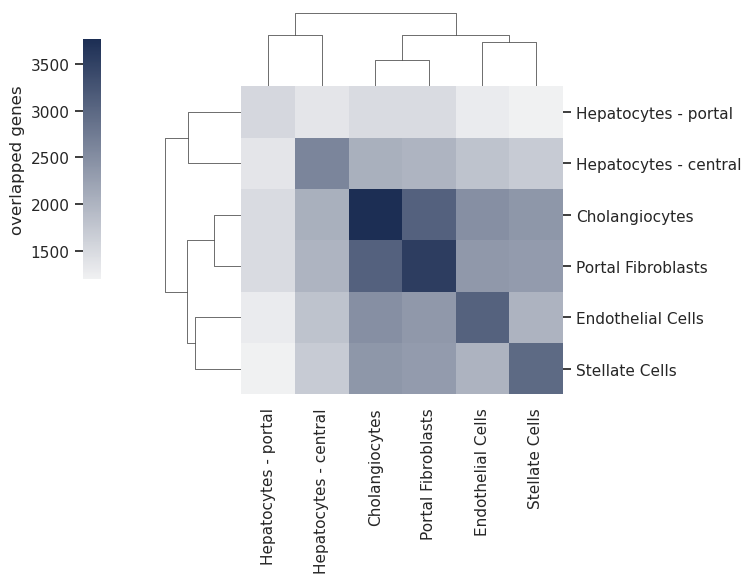

In [6]:
cmap = sns.light_palette("#1C2E54", as_cmap=True, n_colors = 6)
sns.set()
sns.set_style( {'axes.grid' : False})
g = sns.clustermap(overlap_df.astype(int), figsize=(6, 6), cmap = cmap
                   , cbar_kws={'label': 'overlapped genes', 'location': 'left'})
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((-0.1, .52, .03, .4))
plt.savefig(save_path_results+'overlap_matrix_Nault.pdf', bbox_inches='tight')
plt.show()
sns.set()